# Introduce

### Main

Include 3 steps:

1. Step 1: Extract Words from Image
2. Step 2: Labeling 
3. Step 3: Classifying & Displaying

### References

1. Text Detection Using East-Model
1. Detect Words on Receipt using Donut Model

In [1]:
pip install easyocr

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2 
import os
from bs4 import BeautifulSoup

import torch

from keras import layers
from keras.models import Model

from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
W,H = 320, 320

In [5]:
data_path = '/kaggle/input/ocr-receipts-text-detection/images'
box_path = '/kaggle/input/ocr-receipts-text-detection/boxes'
xml_path = '/kaggle/input/ocr-receipts-text-detection/annotations.xml'
east_path = '/kaggle/input/east-model/frozen_east_text_detection.pb'

In [6]:
determined_labels = {'shop': 0, 'item': 1, 'total': 2, 'date_time': 3, 'other': 4}

## Extracting Text

### Solution 1: Using EasyOCR lib
Using EasyOCR model : https://github.com/JaidedAI/EasyOCR#supported-languages

References:
1. https://pyimagesearch.com/2020/09/14/getting-started-with-easyocr-for-optical-character-recognition/

### Solution 2: Using Tesseract lib
Using Tesseract model: https://github.com/tesseract-ocr/tesseract

References:
1. https://pyimagesearch.com/2017/07/10/using-tesseract-ocr-python/

### Solution 3: Building OCR model
.... Updating

In [7]:
class ExtractingText:
    
    def __init__(self, solution: str, usingGPU: bool):
        
        self.gpu = usingGPU
        if 'Terr' or 'Easy' in solution:
            self.sol = solution 
        else:
            print(f"Solution must be 'Tess' or Easy")
            
                     
    def cleanup_text(self, text):
        # strip out non-ASCII text so we can draw the text on the image
        # using OpenCV
        return "".join([c if ord(c) < 128 else "" for c in text]).strip()
            
    """
    Tesseract
    """  
    def Tesseract(self, dtset, min_length):
        if 'Tess' in self.sol:
            import pytesseract
            from PIL import Image
            
            char = []
            for idx in dtset:
                z = []
                image = Image.open(os.path.join(data_path, idx))
                data = pytesseract.image_to_data(image, 
                                                 output_type=pytesseract.Output.DICT)

                for i in range(len(data['text'])):
                    text = data['text'][i]
                    text = self.cleanup_text(text)
                    if len(text) < min_length: continue
                    z.append([text])
                    
                char.append([idx, z])   
            return char
        
        else:
            print("Solution must be 'Tess'")   
            
    """
    EASY OCR
    1. de_prob: probability 's threshold, default: 0.5
    2. languages: default: 'en', processing and extracting "English"
    """
                     
    def get_results(self, ocr_results, de_prob):
        words = []
        for (bbox, text, prob) in ocr_results:
            if prob > de_prob and len(text)>2:
                text = self.cleanup_text(text)  # Assuming cleanup_text is defined elsewhere
                words.append([text])
        return words
    
    def EasyOCR(self, dtset, languages, de_prob=0.5):
        if 'Easy' in self.sol:
            from easyocr import Reader
            char_pos = []
            for idx in dtset:
                img_file = os.path.join(data_path, os.path.basename(idx))
                img = cv2.imread(img_file)
                reader = Reader([languages], gpu=self.gpu)
                results = reader.readtext(img)
                bboxes = self.get_results(results, de_prob)
                char_pos.append([idx, bboxes])
            return char_pos
        else:
            print("Solution must be 'Easy'")
                    

In [8]:
extract_text = ExtractingText('Easy', True)
word_position = extract_text.EasyOCR(sorted(os.listdir(data_path)), 'en', de_prob=0.2)

In [9]:
# extract_text = ExtractingText('Tess', True)
# word_position = extract_text.Tesseract(sorted(os.listdir(data_path)), 5)

# Processing - Preparing Data - Labeling

In [10]:
def get_data(annotation_file, ext_word, split_rate=0.2):
    
    dt_set = []

    with open(annotation_file, 'r') as f:
            data = f.read()
    Bs_data = BeautifulSoup(data, "xml")
    infors = Bs_data.find_all('image')

    for i, idx in enumerate(infors):
        k = []
        z = []
        org_dt = []
        name_file = idx.get('name')
        result = [inner_list[0] for inner_list in ext_word[i][1]]
        boxes = idx.find_all('box')

        for box in boxes:
            attribute_element = box.find('attribute', {'name': 'text'})
            text_content = attribute_element.text if attribute_element else None
            label = box.get('label')
            k.append((text_content, label))
            z.append([text_content, label])
            org_dt = z.copy()

        for x in result:
            match_found = False
            for i, j in k:
                if x in i:
                    z.append([x, j])
                    match_found = True
                    break  # Exit the inner loop once a match is found

            if not match_found:
                z.append([x, 'other'])
        
        
        dt_set.append([name_file, z + org_dt])
    
    train_dt, val_dt = train_test_split(dt_set, test_size=split_rate)
        
    return train_dt, val_dt

In [11]:
train_ds, val_ds = get_data(xml_path, word_position, split_rate=0.4)

# NLP - Classify Text - DistilBert 

In [12]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

import torch.nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [13]:
BATCH_SIZE = 64

In [14]:
def get_NLP_data(ds):
    
    X=[]; y = []
    for index in train_ds:
        for inf in index[1]:
            text = inf[0]
            label = determined_labels[inf[1]]
            X.append(text)
            y.append(label)
        
    return X, y

In [15]:
X_train, y_train = get_NLP_data(train_ds)
X_val, y_val = get_NLP_data(val_ds)

In [16]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

train_data = tokenizer(list(X_train), return_tensors="pt", padding=True, truncation=True)
valid_data = tokenizer(list(X_val), return_tensors="pt", padding=True, truncation=True)

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': torch.tensor(self.labels[idx])
        }

# Create dataset and dataloader
train_dataset = SentimentDataset(
    input_ids=train_data['input_ids'],
    attention_mask=train_data['attention_mask'],
    labels=y_train
)

val_dataset = SentimentDataset(
    input_ids=valid_data['input_ids'],
    attention_mask=valid_data['attention_mask'],
    labels=y_val
)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [17]:
class SaveBestModelCallback:
    def __init__(self, model, save_path):
        self.model = model
        self.save_path = save_path
        self.best_val_loss = float(0.65)  

    def __call__(self, val_loss):
        if val_loss > self.best_val_loss:
            print(f"Validation loss improved ({self.best_val_loss:.6f} --> {val_loss:.6f}). Saving model...")
            torch.save(self.model.state_dict(), self.save_path)
            self.best_val_loss = val_loss
        else:
            print(f"Validation loss did not improve ({self.best_val_loss:.6f} --> {val_loss:.6f}).")

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels = 5)
model = model.to(device)

save_callback = SaveBestModelCallback(model, '/kaggle/working/best_model.pth')
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
from tqdm import tqdm

num_epochs = 12

for epoch in range(num_epochs):
    # Training loop
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    progress_bar = tqdm(enumerate(train_dataloader, 1), total=len(train_dataloader))
    for step, batch in progress_bar:
        batch = {key: value.to(device) for key, value in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = criterion(outputs.logits, batch['labels'])
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        predictions = torch.argmax(outputs.logits, dim=1)
        correct = (predictions == batch['labels']).sum().item()
        total_correct += correct
        total_samples += len(batch['labels'])

        # Accumulate loss
        total_loss += loss.item()

        progress_bar.set_description(f'Epoch {epoch+1}/{num_epochs}, Step {step}/{len(train_dataloader)}')
        progress_bar.set_postfix({'Loss': loss.item(), 'Accuracy': correct / len(batch['labels'])})

    # Calculate training statistics for the epoch
    epoch_loss = total_loss / len(train_dataloader)
    epoch_accuracy = total_correct / total_samples

    # Validation loop
    model.eval()
    val_total_loss = 0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        for val_step, val_batch in enumerate(val_dataloader, 1):
            val_batch = {key: value.to(device) for key, value in val_batch.items()}
            val_outputs = model(**val_batch)
            val_loss = criterion(val_outputs.logits, val_batch['labels'])

            # Calculate accuracy
            val_predictions = torch.argmax(val_outputs.logits, dim=1)
            val_correct = (val_predictions == val_batch['labels']).sum().item()
            val_total_correct += val_correct
            val_total_samples += len(val_batch['labels'])

            # Accumulate loss
            val_total_loss += val_loss.item()

    # Calculate validation statistics for the epoch
    val_epoch_loss = val_total_loss / len(val_dataloader)
    val_epoch_accuracy = val_total_correct / val_total_samples
    
    save_callback(val_epoch_accuracy)

    # Print statistics for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}')

Epoch 1/12, Step 15/15: 100%|██████████| 15/15 [00:01<00:00,  8.13it/s, Loss=1.19, Accuracy=0.636]


Validation loss improved (0.650000 --> 0.756340). Saving model...
Epoch 1/12, Loss: 1.3391, Accuracy: 0.5854, Val Loss: 1.0041, Val Accuracy: 0.7563


Epoch 2/12, Step 15/15: 100%|██████████| 15/15 [00:01<00:00, 11.48it/s, Loss=0.898, Accuracy=0.727]


Validation loss improved (0.756340 --> 0.777288). Saving model...
Epoch 2/12, Loss: 0.8856, Accuracy: 0.7530, Val Loss: 0.7131, Val Accuracy: 0.7773


Epoch 3/12, Step 15/15: 100%|██████████| 15/15 [00:01<00:00, 11.37it/s, Loss=1.39, Accuracy=0.545]


Validation loss improved (0.777288 --> 0.839030). Saving model...
Epoch 3/12, Loss: 0.6872, Accuracy: 0.7828, Val Loss: 0.5014, Val Accuracy: 0.8390


Epoch 4/12, Step 15/15: 100%|██████████| 15/15 [00:01<00:00, 11.46it/s, Loss=0.664, Accuracy=0.727]


Validation loss improved (0.839030 --> 0.869901). Saving model...
Epoch 4/12, Loss: 0.5034, Accuracy: 0.8423, Val Loss: 0.3987, Val Accuracy: 0.8699


Epoch 5/12, Step 15/15: 100%|██████████| 15/15 [00:01<00:00, 11.48it/s, Loss=0.409, Accuracy=0.727]


Validation loss improved (0.869901 --> 0.919515). Saving model...
Epoch 5/12, Loss: 0.3815, Accuracy: 0.8798, Val Loss: 0.2651, Val Accuracy: 0.9195


Epoch 6/12, Step 15/15: 100%|██████████| 15/15 [00:01<00:00, 11.41it/s, Loss=0.0733, Accuracy=1]


Validation loss improved (0.919515 --> 0.934950). Saving model...
Epoch 6/12, Loss: 0.2729, Accuracy: 0.9107, Val Loss: 0.2221, Val Accuracy: 0.9350


Epoch 7/12, Step 15/15: 100%|██████████| 15/15 [00:01<00:00, 11.47it/s, Loss=0.192, Accuracy=1]


Validation loss improved (0.934950 --> 0.972437). Saving model...
Epoch 7/12, Loss: 0.2200, Accuracy: 0.9405, Val Loss: 0.1356, Val Accuracy: 0.9724


Epoch 8/12, Step 15/15: 100%|██████████| 15/15 [00:01<00:00, 11.49it/s, Loss=0.336, Accuracy=0.909]


Validation loss improved (0.972437 --> 0.976847). Saving model...
Epoch 8/12, Loss: 0.1712, Accuracy: 0.9691, Val Loss: 0.1126, Val Accuracy: 0.9768


Epoch 9/12, Step 15/15: 100%|██████████| 15/15 [00:01<00:00, 11.50it/s, Loss=0.0778, Accuracy=1]


Validation loss improved (0.976847 --> 0.979052). Saving model...
Epoch 9/12, Loss: 0.1405, Accuracy: 0.9669, Val Loss: 0.1115, Val Accuracy: 0.9791


Epoch 10/12, Step 15/15: 100%|██████████| 15/15 [00:01<00:00, 11.44it/s, Loss=0.207, Accuracy=0.909]


Validation loss improved (0.979052 --> 0.984564). Saving model...
Epoch 10/12, Loss: 0.1066, Accuracy: 0.9824, Val Loss: 0.0794, Val Accuracy: 0.9846


Epoch 11/12, Step 15/15: 100%|██████████| 15/15 [00:01<00:00, 11.51it/s, Loss=0.0355, Accuracy=1]


Validation loss did not improve (0.984564 --> 0.977949).
Epoch 11/12, Loss: 0.0930, Accuracy: 0.9768, Val Loss: 0.0832, Val Accuracy: 0.9779


Epoch 12/12, Step 15/15: 100%|██████████| 15/15 [00:01<00:00, 11.48it/s, Loss=0.0143, Accuracy=1]


Validation loss improved (0.984564 --> 0.985667). Saving model...
Epoch 12/12, Loss: 0.0797, Accuracy: 0.9791, Val Loss: 0.0567, Val Accuracy: 0.9857


In [20]:
pred_values = []
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels = 5)
try:
    model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
except:
    model = model

for i in X_val:
    test_data = tokenizer(i, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**test_data)
        logits = outputs.logits

    # Convert logits to probabilities and get predicted label
    probabilities = torch.softmax(logits, dim=-1)
    predicted_label = torch.argmax(probabilities, dim=-1).item()
    
    pred_values.append(predicted_label)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


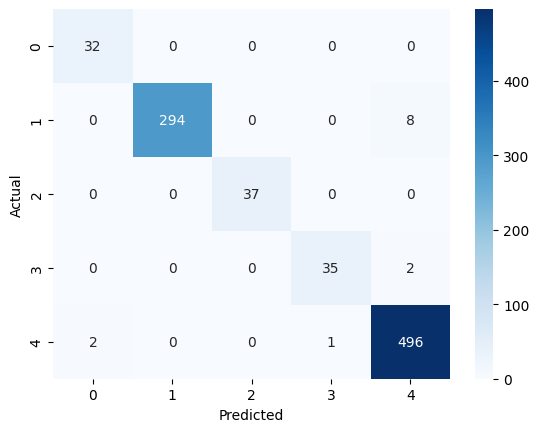

In [21]:
conf_matrix = confusion_matrix(y_val, pred_values)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display

In [22]:
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels = 5)
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [23]:
def easyOCR_results(image, title, min_len):
    from easyocr import Reader
    img = cv2.imread(image)
    reader = Reader(['en'], gpu=True)
    results = reader.readtext(img)

    for (bbox, text, prob) in results:
        if prob > int(min_len/100) and len(text) > min_len:
            (tl, tr, br, bl) = bbox
            tl = (int(tl[0]), int(tl[1]))
            tr = (int(tr[0]), int(tr[1]))
            br = (int(br[0]), int(br[1]))
            bl = (int(bl[0]), int(bl[1]))

            text = extract_text.cleanup_text(text)
            tknz = tokenizer(text, return_tensors="pt")

            with torch.no_grad():
                outputs = model(**tknz)
                logits = outputs.logits

            probabilities = torch.softmax(logits, dim=-1)
            predicted_label = torch.argmax(probabilities, dim=-1).item()

            for label, value in determined_labels.items():
                 if value == predicted_label:
                        text = label

            if 'shop' in text:
                cv2.rectangle(img, tl, br, (255, 0, 0), 2)
                cv2.putText(img, text, (tl[0], tl[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

            elif 'item' in text:
                cv2.rectangle(img, tl, br, (0, 175, 0), 2)
                cv2.putText(img, text, (tl[0], tl[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 175, 0), 2)
            elif 'total' in text:
                cv2.rectangle(img, tl, br, (0, 0, 255), 2)
                cv2.putText(img, text, (tl[0], tl[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

            elif 'other' in text:
                cv2.rectangle(img, tl, br, (0, 0, 0), 2)
                cv2.putText(img, text, (tl[0], tl[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)

            else:
                cv2.rectangle(img, tl, br, (255, 175, 0), 2)
                cv2.putText(img, text, (tl[0], tl[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 175, 0), 2)
                
    plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [24]:
def Tess_results(image, title, min_len):
    import pytesseract
    img = cv2.imread(image)
    data = pytesseract.image_to_data(image, 
                                     output_type=pytesseract.Output.DICT)
    
    for i in range(len(data['text'])):
        text = data['text'][i]
        text = extract_text.cleanup_text(text)
        if len(text) < min_len: continue
            
        tknz = tokenizer(text, return_tensors="pt")

        with torch.no_grad():
            outputs = model(**tknz)
            logits = outputs.logits

        probabilities = torch.softmax(logits, dim=-1)
        predicted_label = torch.argmax(probabilities, dim=-1).item()

        for label, value in determined_labels.items():
             if value == predicted_label:
                    text = label
                    
        x, y, width, height = int(data['left'][i]), int(data['top'][i]), int(data['width'][i]), int(data['height'][i])
        
        if 'shop' in text:
            cv2.rectangle(img, (x, y), (x + width, y + height), (255, 0, 0), 2)
            cv2.putText(img, text, (x, y - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
    
        elif 'item' in text:
                cv2.rectangle(img, (x, y), (x + width, y + height), (0, 175, 0), 2)
                cv2.putText(img, text, (x, y - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 175, 0), 2)
        elif 'total' in text:
            cv2.rectangle(img, (x, y), (x + width, y + height), (0, 0, 255), 2)
            cv2.putText(img, text, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        elif 'other' in text:
            cv2.rectangle(img, (x, y), (x + width, y + height), (0, 0, 0), 2)
            cv2.putText(img, text, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)

        else:
            cv2.rectangle(img, (x, y), (x + width, y + height), (255, 175, 0), 2)
            cv2.putText(img, text, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 175, 0), 2)
                
    plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [25]:
def display_results(test_dt, method='Easy', min_len=5):
    file_val = [inner_list[0] for inner_list in test_dt]
    if method == 'Easy':
        for idx in file_val:
            img_file = os.path.join(data_path, os.path.basename(idx))
            easyOCR_results(img_file, idx, min_len)
            
    elif method == 'Tess':
        for idx in file_val:
            img_file = os.path.join(data_path, os.path.basename(idx))
            Tess_results(img_file, idx, min_len)
            
    else:
        print("Method must be 'Tess' or 'Easy'")
        

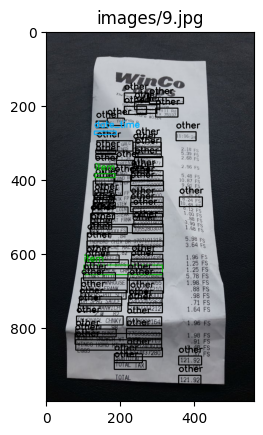

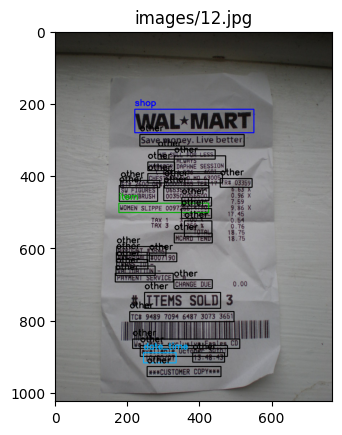

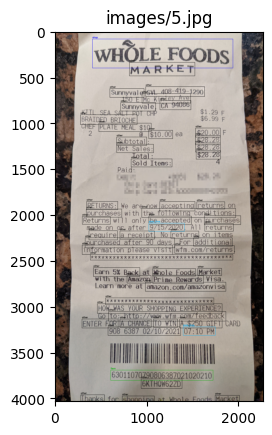

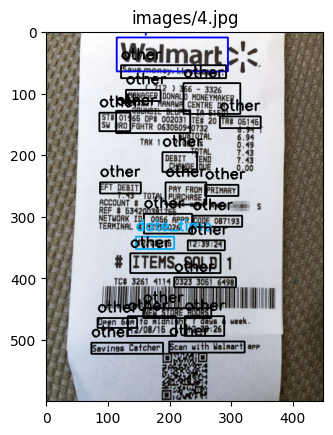

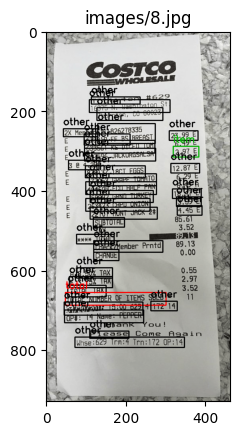

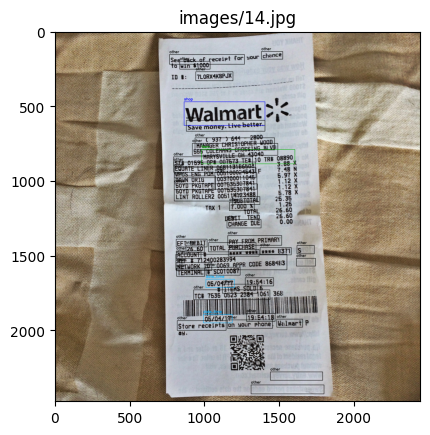

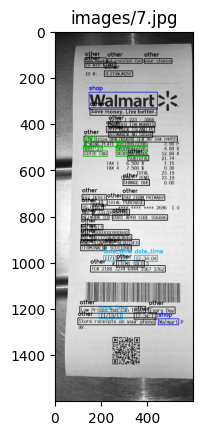

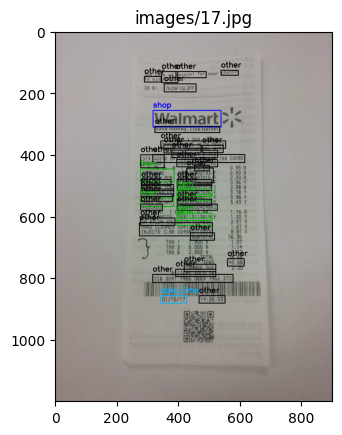

In [26]:
display_results(val_ds, method='Easy', min_len=5)

# Others

## Text Detection

Download model: https://www.dropbox.com/s/r2ingd0l3zt8hxs/frozen_east_text_detection.tar.gz?dl=1

References:
1. https://pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/
1. https://learnopencv.com/deep-learning-based-text-detection-using-opencv-c-python/

In [27]:
pip install --upgrade imutils

  Preparing metadata (setup.py) ... - \ done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=be04a63e7329664e5098d19d6a49c05879042f693d333f9f17c2c322c7f8c722
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [28]:
from imutils.object_detection import non_max_suppression
import numpy as np
import time
import cv2

In [29]:
layerNames = ["feature_fusion/Conv_7/Sigmoid",
              "feature_fusion/concat_3"]

In [30]:
def model_resutls(scores, geometry):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
        
        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < 0.5:
                continue
            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append([startX, startY, endX, endY])
            confidences.append(scoresData[x])
            
    # NMS 
    boxes = non_max_suppression(np.array(rects), probs=confidences)
            
    return boxes

In [31]:
def detectText(dtset, model_path):
    
    bboxes = []
    
    for idx in dtset:
        
        # Read/ resize image
        image_file = os.path.join(data_path, os.path.basename(idx[0]))
        img = cv2.imread(image_file)
        img = cv2.resize(img, (W, H))
        
        # Load model 
        net = cv2.dnn.readNet(model_path)
        
        # Detect
        blob = cv2.dnn.blobFromImage(img, 1.0, (W, H), 
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)
        net.setInput(blob)
        (scores, geometry) = net.forward(layerNames)
        
        # Get results 
        boxes = model_resutls(scores, geometry)
        
        bboxes.append(boxes)
        
    return bboxes
        

In [32]:
def draw_bbox(dtset):
    
    bb = detectText(val_ds, east_path)
    
    for i, idx in enumerate(dtset):
        file = os.path.join(data_path, os.path.basename(idx[0]))
        img = cv2.imread(file)
        img = cv2.resize(img, (W,H))
        
        for k in bb[i]:
            cv2.rectangle(img, (k[0], k[1]), (k[2], k[3]), (0,0,0,0))
            
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()  # Show each image separately

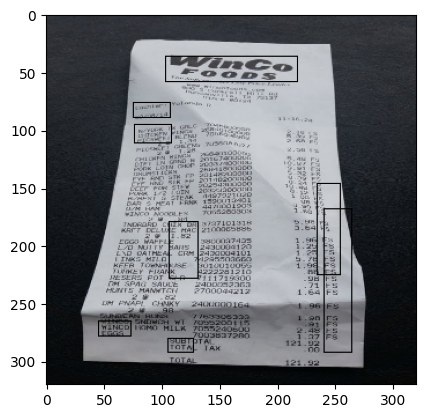

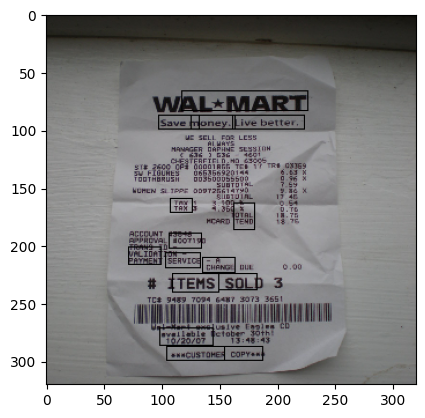

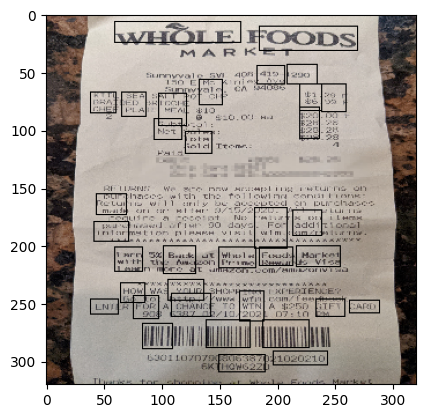

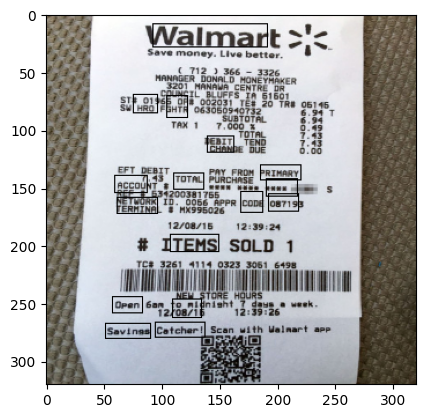

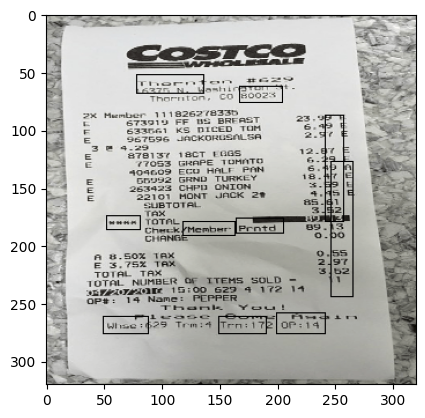

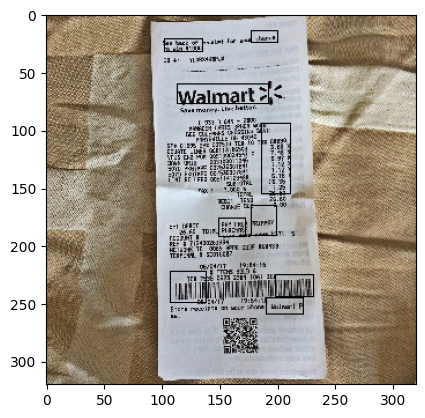

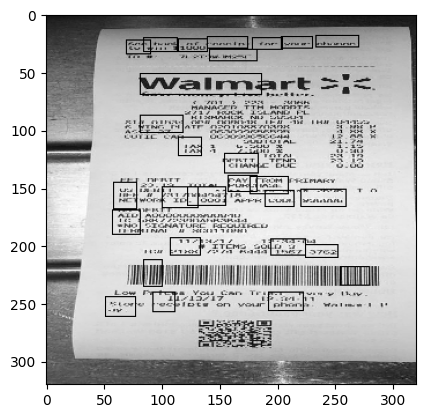

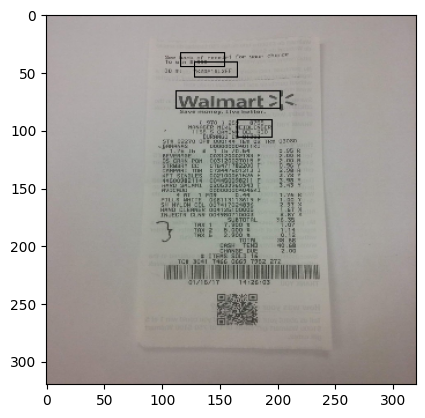

In [33]:
draw_bbox(val_ds)

# Donut Model

In [34]:
pip install -q transformers datasets sentencepiece

Note: you may need to restart the kernel to use updated packages.


In [35]:
pip install -q pytorch-lightning wandb

Note: you may need to restart the kernel to use updated packages.


In [36]:
pip install datasets --upgrade

  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/ec/93/454ada0d1b289a0f4a86ac88dbdeab54921becabac45da3da787d136628f/datasets-2.16.1-py3-none-any.whl.metadata
  Obtaining dependency information for pyarrow-hotfix from https://files.pythonhosted.org/packages/e4/f4/9ec2222f5f5f8ea04f66f184caafd991a39c8782e31f5b0266f101cb68ca/pyarrow_hotfix-0.6-py3-none-any.whl.metadata
  Obtaining dependency information for fsspec[http]<=2023.10.0,>=2023.1.0 from https://files.pythonhosted.org/packages/e8/f6/3eccfb530aac90ad1301c582da228e4763f19e719ac8200752a4841b0b2d/fsspec-2023.10.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.12.2
    Uninstalling fsspec-2023.12.2:
      Successfully uninstalled fsspec-2023.12.2
  Attempting uninstall: datasets

In [37]:
from datasets import load_dataset

dataset = load_dataset("naver-clova-ix/cord-v2")
     

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

In [38]:
import re

from transformers import DonutProcessor, VisionEncoderDecoderModel
from datasets import load_dataset
import torch
import cv2

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
# load document image
image = cv2.imread('/kaggle/input/ocr-receipts-text-detection/images/5.jpg')

# prepare decoder inputs
task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

pixel_values = processor(image, return_tensors="pt").pixel_values

outputs = model.generate(
    pixel_values.to(device),
    decoder_input_ids=decoder_input_ids.to(device),
    max_length=model.decoder.config.max_position_embeddings,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    use_cache=True,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
)

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(processor.token2json(sequence))

preprocessor_config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


tokenizer_config.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.02M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/335 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/806M [00:00<?, ?B/s]

{'menu': [{'nm': 'WHOLE FOODS'}, {'nm': 'Sunnyvale SVL 408-419-1290', 'price': '$1.29 F'}, {'nm': 'BRAIDED BRIOCHE', 'num': '$20.00 F', 'price': '$28.00 F'}], 'sub_total': {'subtotal_price': '$28.28'}, 'total': {'total_price': '$28.28', 'menuqty_cnt': '4'}}
